# Forecasting Energy Demand With Keras
The purpose of thie notebook is perform exploratory data analysis of Google chrome browsing history across all the devices. This is just a fun project I did to investigate my internet browsing pattern and trend. 


The first step is to get the past one year browsing data; Google chrome stores the past 3 months of history on a device in SQLite format. One can download past one year data from Google TakeOut and exported it into JSON format. The history does not provide any information about how much time one spent on each tab rather it provides information about number of vsists and time of visits to any website. Google does not provide any information on session or the duration.

In [387]:
import pandas as pd
import tldextract
import json
with open("/Users/sopank/Downloads/Electric_price_prediction/Takeout/Chrome/BrowserHistory.json") as f:
    data = json.loads(f.read())
    df = pd.DataFrame(data["Browser History"])
# A possible param if differentiation is needed b/w different clients
df.drop('client_id', axis=1, inplace=True)
df.drop('favicon_url', axis=1, inplace=True)
df.sample(1)

,page_transition,title,url,time_usec
134071,GENERATED,Climate change jobs Regina - Google Search,https://www.google.com/search?q=Climate+change...,1616565688645156


In [388]:
df['page_transition'].value_counts()

LINK             96778
TYPED            35537
FORM_SUBMIT      10299
GENERATED         5565
RELOAD            3447
AUTO_BOOKMARK       89
AUTO_TOPLEVEL       53
Name: page_transition, dtype: int64

In [389]:
df['page_transition'].unique()
df = df[(df['page_transition'] == "LINK") | (df['page_transition'] == "TYPED")
       | (df['page_transition'] == "FORM_SUBMIT") | (df['page_transition'] == "GENERATED")]

Convert time (in microseconds) to human-readable datetime format to derive features from it like hour, day, month, or day_of_week. 
Used tldextract python module to extract domain, subdomain, and other information from the URL field.

In [390]:
def convert_time(x):
    return datetime.fromtimestamp(x/1000000)

def hr_func(ts):
    return ts.hour

days_arr = ["Mon","Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]
def get_day_of_week(x):
    return days_arr[x.weekday()]
def month_func(ts):
    return ts.month

def get_domain(x):
    domain = tldextract.extract(x)[1]
    sub_domain = tldextract.extract(x)[0]
    if sub_domain == "mail":
        return sub_domain + "." + domain
    # Ugly hack to differentiate b/w drive.google.com and google.com
    if domain == "google" and sub_domain=="www":
        return "google_search" 
    return domain
# time_usec column is picked and for each row, convert_time(row) is called. The result is stored in the same dataframe under column dt
df['dt'] = df['time_usec'].apply(convert_time)
df['hour'] = df['dt'].apply(hr_func)
df['days'] = df['dt'].apply(get_day_of_week)
df['month'] = df['dt'].apply(month_func)
df['domain'] = df['url'].apply(get_domain)

Plot most visted websites

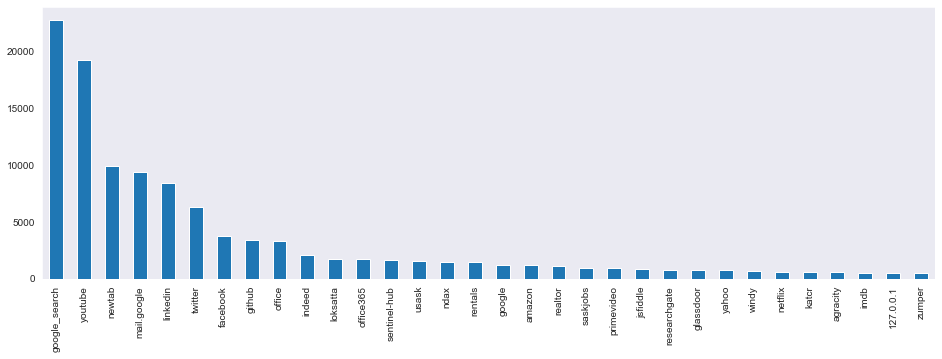

In [393]:
df2=df['domain'].value_counts()
df3 = df2[(df2>500 )].copy()
plt.figure(figsize = (16,5))
df3.plot.bar()

Create groups based on websites

In [395]:
def get_category(x):
    if x in ["github","udemy","youtube","edx","coursera"]:
        return "Learning"
    elif x in ["indeed", "linkedin","glassdoor", "saskjobs"]:
        return "JobSearch"
    elif x in ["lookmovie", "limetorrent"]:
        return "Entertainment"
    elif x in ["rental", "realtor","zumper","kijiji"]:
        return "RealEstate"
    elif x in ["facebook", "twitter","instagram"]:
        return "Social"
    elif x in ["amazon", "mark","sportcheck","newbalance"]:
        return "Shopping"
    else:
        return "Other"
# Cluster popular domains into a category
df['category'] = df['domain'].apply(get_category)


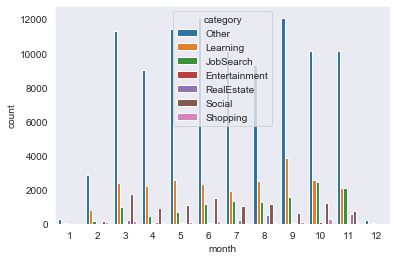

In [396]:
import seaborn as sns
sns.countplot(x="month", hue="category", data=df)

Hourly plot showing how I used internet everyday in past year

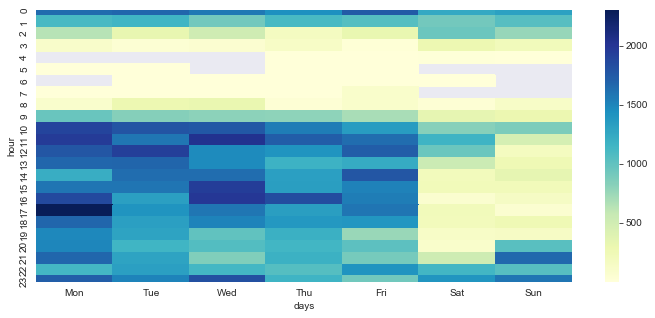

In [398]:
df_heat = df.groupby(["hour", "days"])["domain"].size().reset_index()
df_heat2 = df_heat.pivot("hour", "days", "domain")
plt.figure(figsize = (12,5))
sns.heatmap(df_heat2[days_arr] , cmap="YlGnBu")

Same plot as above but for monthly 

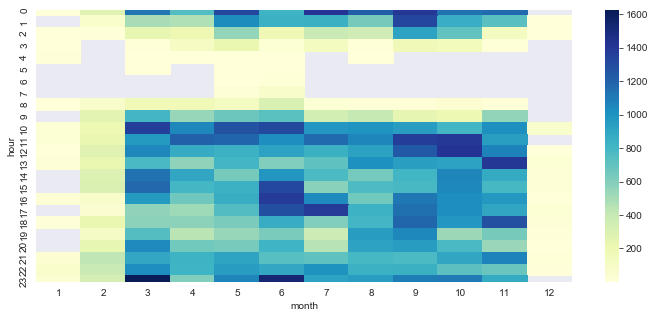

In [400]:
df_heat = df.groupby(["hour", "month"])["domain"].size().reset_index()
df_heat2 = df_heat.pivot("hour", "month", "domain")
plt.figure(figsize = (12,5))
sns.heatmap(df_heat2 , cmap="YlGnBu")

Pass the category and period (hor, day, month etc) to plotting function

<Figure size 864x360 with 0 Axes>

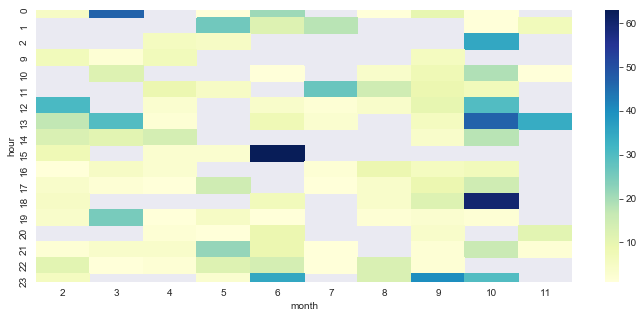

In [413]:
def plot_sns(category,period):
    df_heat = df[df['category'] == category].groupby(['hour', period])["domain"].size().reset_index()
    df_heat2 = df_heat.pivot("hour", period,"domain")
    plt.figure(figsize = (12,5))
    if period == "days":
        sns.heatmap(df_heat2[['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']].copy() , cmap="YlGnBu")
    else:
        plt.figure(figsize = (12,5))
        sns.heatmap(df_heat2, cmap="YlGnBu")
    
plot_sns("Shopping","month")

### Marginal distribution of category vs time

/Users/sopank/miniconda3/envs/water_demand/lib/python3.9/site-packages/seaborn/axisgrid.py:2076: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


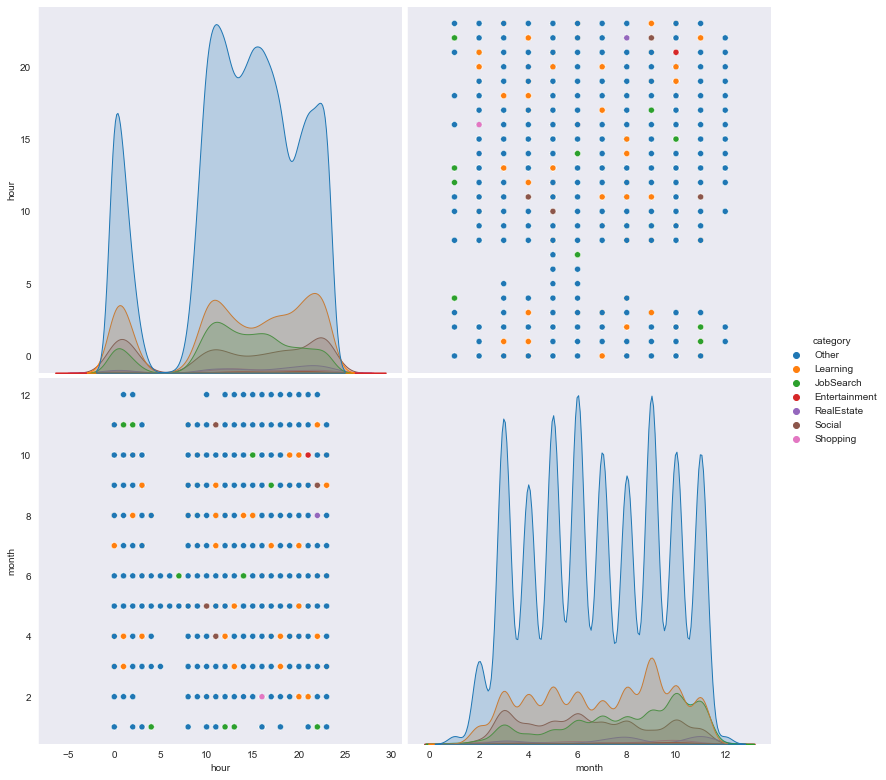

In [372]:
df3=df.drop(columns=['dt','time_usec']).copy()
sns.pairplot(df3, hue="category",size=5.5)